# Dry Bean

https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset

## Data Set Information:

Seven different types of dry beans were used in this research, taking into account the features such as form, shape, type, and structure by the market situation. A computer vision system was developed to distinguish seven different registered varieties of dry beans with similar features in order to obtain uniform seed classification. For the classification model, images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. Bean images obtained by computer vision system were subjected to segmentation and feature extraction stages, and a total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.


Attribute Information:

01. Area (A): The area of a bean zone and the number of pixels within its boundaries.
02. Perimeter (P): Bean circumference is defined as the length of its border.
03. Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.
04. Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
05. Aspect ratio (K): Defines the relationship between L and l.
06. Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.
07. Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
08. Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.
09. Extent (Ex): The ratio of the pixels in the bounding box to the bean area.
10. Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
11. Roundness (R): Calculated with the following formula: (4piA)/(P^2)
12. Compactness (CO): Measures the roundness of an object: Ed/L
13. ShapeFactor1 (SF1)
14. ShapeFactor2 (SF2)
15. ShapeFactor3 (SF3)
16. ShapeFactor4 (SF4)
17. Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)

## Imports

In [198]:
import re  # Regex

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

## Global parameters setup

In [199]:
# @formatter:off
%matplotlib inline
# @formatter:on

plt.ioff()

"""
Executing methods that do some data transformation which involves randomness
(i.e. sampling or data splitting) yields different result for each run. In order
 to have predictable results we can leverage the function argument called
 `random_state` and set it to a constant value (`randomness_id`).
"""
randomness_id = 42
np.random.seed(randomness_id)

## Dataset loading

In [200]:
df = pd.read_excel("./data/Dry_Bean_Dataset.xlsx")
df.shape[0]

13611

In [201]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [202]:
df.columns = map(lambda name: re.sub("(?!^)([A-Z]+)", r"_\1", name).lower(), df.columns)

## Missing data

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   area               13611 non-null  int64  
 1   perimeter          13611 non-null  float64
 2   major_axis_length  13611 non-null  float64
 3   minor_axis_length  13611 non-null  float64
 4   aspect_ration      13611 non-null  float64
 5   eccentricity       13611 non-null  float64
 6   convex_area        13611 non-null  int64  
 7   equiv_diameter     13611 non-null  float64
 8   extent             13611 non-null  float64
 9   solidity           13611 non-null  float64
 10  roundness          13611 non-null  float64
 11  compactness        13611 non-null  float64
 12  shape_factor1      13611 non-null  float64
 13  shape_factor2      13611 non-null  float64
 14  shape_factor3      13611 non-null  float64
 15  shape_factor4      13611 non-null  float64
 16  class              136

In [204]:
df.isnull().sum()

area                 0
perimeter            0
major_axis_length    0
minor_axis_length    0
aspect_ration        0
eccentricity         0
convex_area          0
equiv_diameter       0
extent               0
solidity             0
roundness            0
compactness          0
shape_factor1        0
shape_factor2        0
shape_factor3        0
shape_factor4        0
class                0
dtype: int64

## Data correlation

<AxesSubplot:>

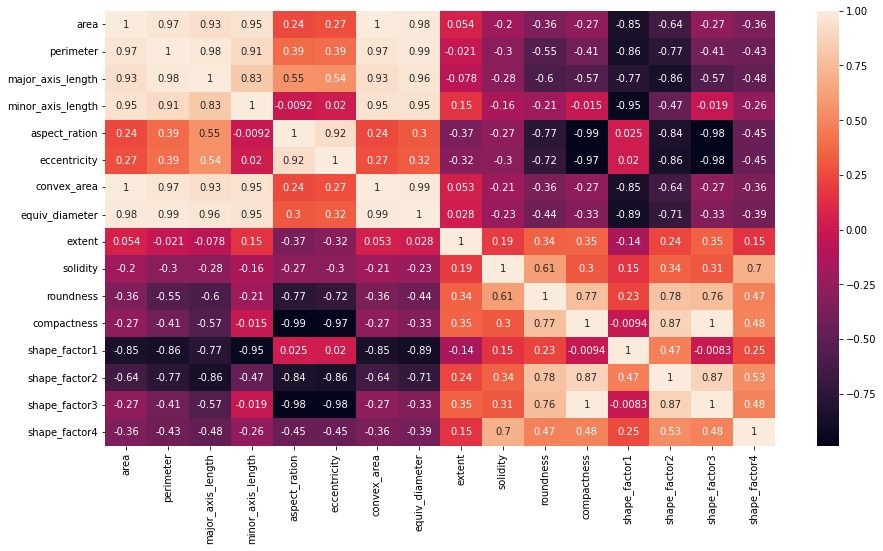

In [205]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True)

In [206]:
def trim_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)] * 2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out


df = pd.concat([trim_correlated(df, 0.95), df["class"]], axis=1)

label_encoder = LabelEncoder()
label_encoder.fit(df["class"])
df["class"] = label_encoder.transform(df["class"])

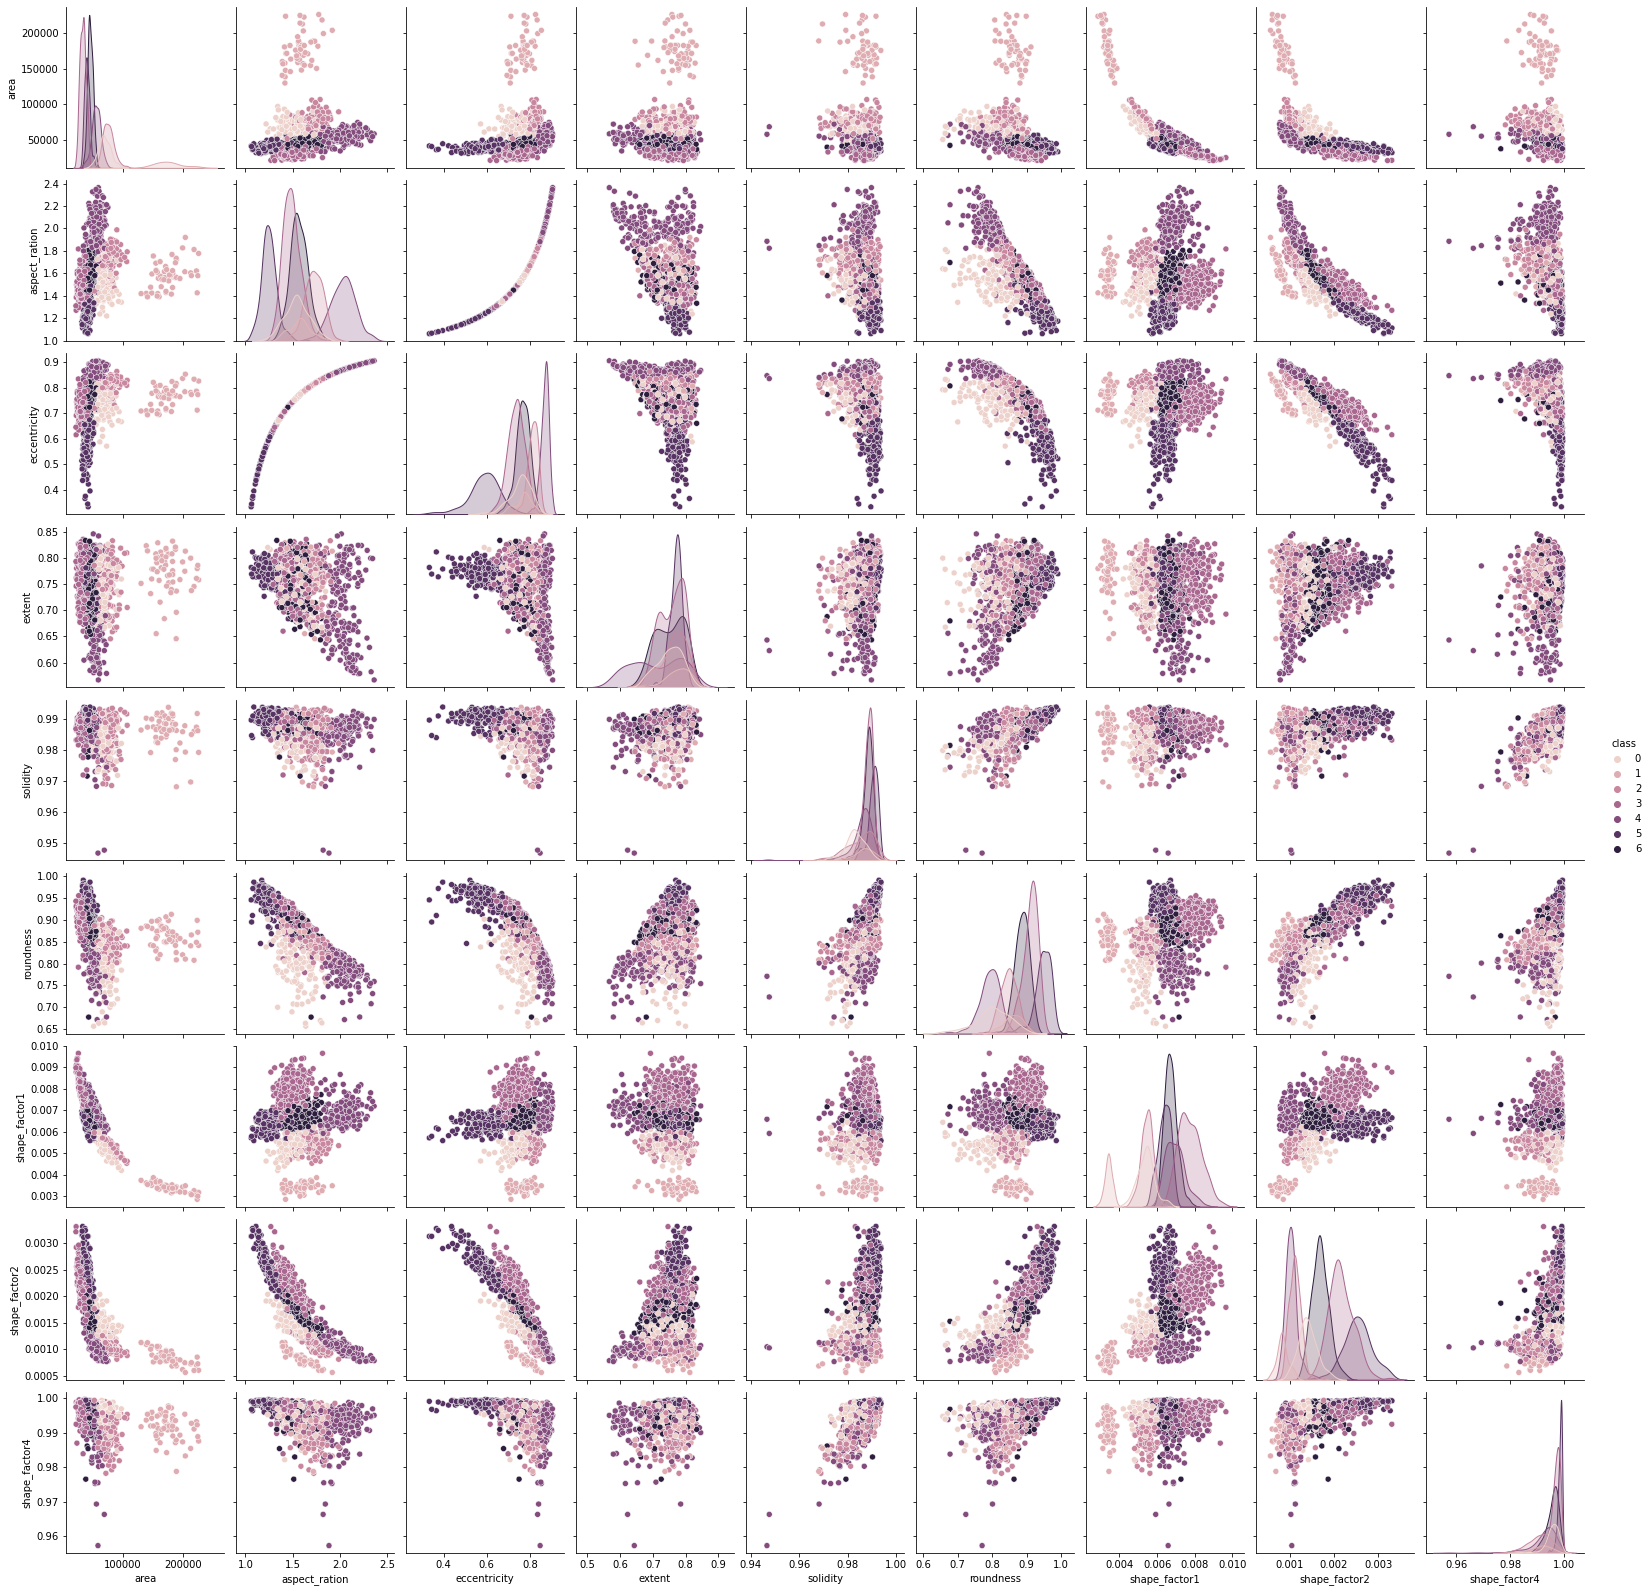

In [207]:
sns.pairplot(pd.DataFrame.sample(df, frac=0.1, random_state=randomness_id), hue="class")

## Data balancing

In [208]:
df["class"].value_counts()

3    3546
6    2636
5    2027
4    1928
2    1630
0    1322
1     522
Name: class, dtype: int64

In [209]:
# df = original_df.groupby('class', as_index=False).apply(
#     lambda x: x.sample(original_df["class"].value_counts().min(), random_state=randomness_id)
# ).reset_index(drop=True)
df = df.sample(frac=1, random_state=randomness_id)

## Outliers

In [210]:
df.describe()

,area,aspect_ration,eccentricity,extent,solidity,roundness,shape_factor1,shape_factor2,shape_factor4,class
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,1.583242,0.750895,0.749733,0.987143,0.873282,0.006564,0.001716,0.995063,3.532657
std,29324.095717,0.246678,0.092002,0.049086,0.004660,0.059520,0.001128,0.000596,0.004366,1.828709
min,20420.000000,1.024868,0.218951,0.555315,0.919246,0.489618,0.002778,0.000564,0.947687,0.000000
25%,36328.000000,1.432307,0.715928,0.718634,0.985670,0.832096,0.005900,0.001154,0.993703,2.000000
50%,44652.000000,1.551124,0.764441,0.759859,0.988283,0.883157,0.006645,0.001694,0.996386,3.000000
75%,61332.000000,1.707109,0.810466,0.786851,0.990013,0.916869,0.007271,0.002170,0.997883,5.000000
max,254616.000000,2.430306,0.911423,0.866195,0.994677,0.990685,0.010451,0.003665,0.999733,6.000000


In [211]:
# area_std = df["area"].std()
# df = df[(df["area"].abs() < (3 * area_std))]
# print(original_df.shape[0], df.shape[0])

In [212]:
df.describe()

,area,aspect_ration,eccentricity,extent,solidity,roundness,shape_factor1,shape_factor2,shape_factor4,class
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,1.583242,0.750895,0.749733,0.987143,0.873282,0.006564,0.001716,0.995063,3.532657
std,29324.095717,0.246678,0.092002,0.049086,0.004660,0.059520,0.001128,0.000596,0.004366,1.828709
min,20420.000000,1.024868,0.218951,0.555315,0.919246,0.489618,0.002778,0.000564,0.947687,0.000000
25%,36328.000000,1.432307,0.715928,0.718634,0.985670,0.832096,0.005900,0.001154,0.993703,2.000000
50%,44652.000000,1.551124,0.764441,0.759859,0.988283,0.883157,0.006645,0.001694,0.996386,3.000000
75%,61332.000000,1.707109,0.810466,0.786851,0.990013,0.916869,0.007271,0.002170,0.997883,5.000000
max,254616.000000,2.430306,0.911423,0.866195,0.994677,0.990685,0.010451,0.003665,0.999733,6.000000


## Data preparation

In [213]:
X = df.drop("class", axis=1).copy()
y = df["class"].copy()

# cv_split = KFold(n_splits=10, shuffle=True, random_state=randomness_id)
cv_split = StratifiedKFold(n_splits=10, shuffle=True, random_state=randomness_id)

## Models

In [214]:
def train_and_evaluate(X, y, classifier, cv_split):
    pipeline = make_pipeline(StandardScaler(), classifier)
    accuracy = cross_val_score(pipeline, X, y, cv=cv_split, scoring="accuracy", n_jobs=-1)
    predicted = cross_val_predict(pipeline, X, y, cv=cv_split, n_jobs=-1)
    return accuracy.mean(), ConfusionMatrixDisplay.from_predictions(y, predicted, ax=plt.subplots(figsize=(8, 8))[1])

### Dummy classifier

0.14576469966261743


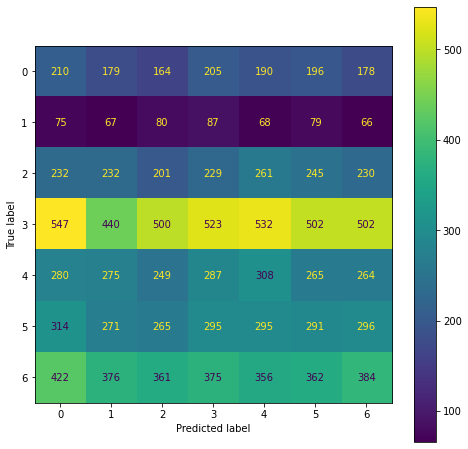

In [215]:
dc_accuracy, dc_confusion = train_and_evaluate(X, y, DummyClassifier(strategy="uniform", random_state=randomness_id),
                                               cv_split)
print(dc_accuracy)
dc_confusion

### Decision tree

0.898023447387416


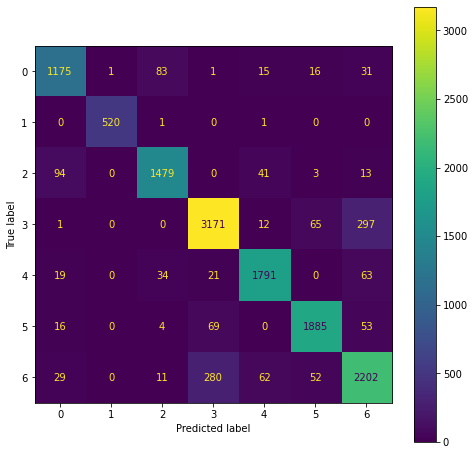

In [216]:
dt_accuracy, dt_confusion = train_and_evaluate(X, y, DecisionTreeClassifier(random_state=randomness_id), cv_split)
print(dt_accuracy)
dc_confusion

### K-nearest neighbours

0.9217548101562187


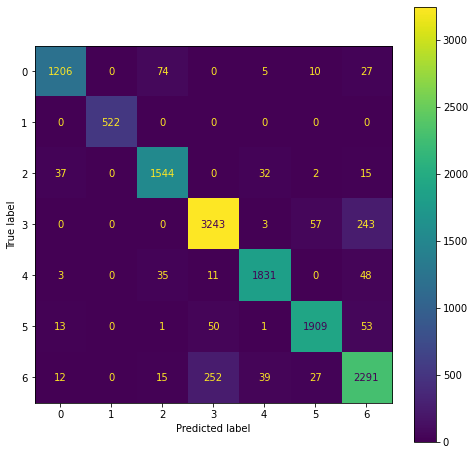

In [217]:
knn_accuracy, knn_confusion = train_and_evaluate(X, y, KNeighborsClassifier(), cv_split)
print(knn_accuracy)
dc_confusion

### Logistic regression

0.9242527574848328


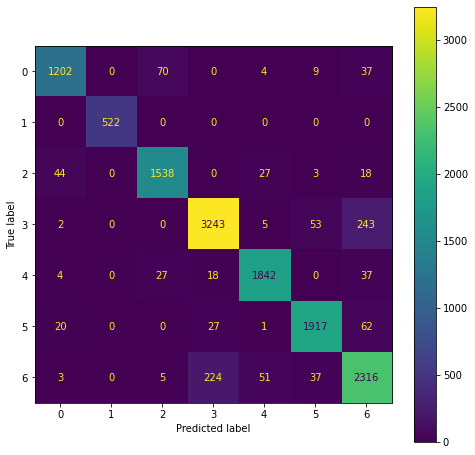

In [218]:
lr_accuracy, lr_confusion = train_and_evaluate(X, y, LogisticRegression(solver='lbfgs', max_iter=400,
                                                                        random_state=randomness_id), cv_split)
print(lr_accuracy)
lr_confusion

### Random forest

0.9264570190572062


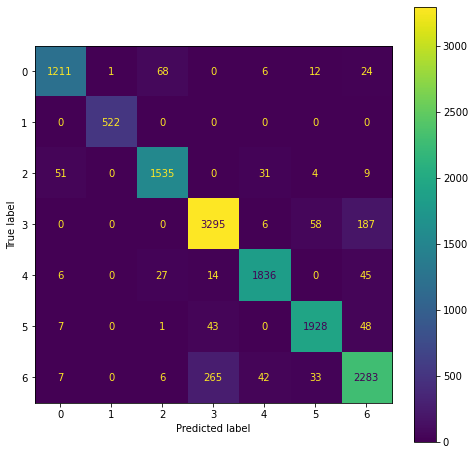

In [219]:
rf_accuracy, rf_confusion = train_and_evaluate(X, y, RandomForestClassifier(random_state=randomness_id), cv_split)
print(rf_accuracy)
rf_confusion